In [1]:
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import shelve
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pymongo import MongoClient
import math

from scripts import blazmass_tools
from scripts import utils
from scripts.analysis import build_loci
from scripts.analysis import taxonomy
from scripts.analysis import DBInfo

In [2]:
# Start and test DB connections
dbinfo = DBInfo.DBInfo('compil_mgm')
t = taxonomy.Taxonomy(host="wl-cmadmin", port=27017)
protDB = dbinfo.protDB
seqDB = dbinfo.seqDB
taxDB = MongoClient('wl-cmadmin', 27017)["TaxDB_20151009"]["TaxDB_20151009"]
taxDB.find_one()

{'_id': 2,
 'exact_match': True,
 'matched_organism': 'Paenibacillus phage phiIBB_Pl23',
 'organism': 'Paenibacillus phage phiIBB_Pl23',
 'taxid': 1337877}

In [3]:
# Load data
BASE = '../data'
OUT = BASE + '/tax_data'

samples = shelve.open(os.path.join(BASE, 'samples.shelve'))
protein_clusters = shelve.open(os.path.join(BASE, 'protein_clusters.shelve'))

metadata = pd.read_csv(os.path.join(BASE,"filt_metadata.csv"), index_col=0)
samp_names = list(metadata.index)

unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"))
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci.pkl.gz"))
grouped_loci = utils.load(os.path.join(BASE,"grouped_loci.pkl.gz"))

In [4]:
# Filter out unused samples
samps = {k:v for k, v in samples.items() if k in samp_names}

In [5]:
sample_pairs = metadata.reset_index().set_index(['enriched', 'technical']).sort_index().groupby(level=[0,1])

pairs = []
for x, y in sample_pairs:
    pairs.append(list(y['index'].values))

n14_samps = [x[0] for x in pairs]
n15_samps = [x[1] for x in pairs]

n14_un_samps = [x for x in n14_samps if x.startswith('UL_')]
n15_un_samps = [x for x in n15_samps if x.startswith('UL_')]

n14_enr_samps = [x for x in n14_samps if x.startswith('CL_')]
n15_enr_samps = [x for x in n15_samps if x.startswith('CL_')]

In [6]:
ctl_samps = []
for samp_name, samp in samples.items():
    if samp['probe'] == 'DMSO':
        ctl_samps.append(samp_name)

In [7]:
peptides_to_filter = []
for sample in ctl_samps:
    for locus in protein_clusters[sample]:
        if locus.quantification['counts'] >= 10:
            peptides_to_filter += list(locus.peptide_quant.keys())
peptides_to_filter = set(peptides_to_filter)

In [8]:
dfs = dict()
dfs["phylum"] = dict()
dfs["family"] = dict()

In [9]:
sample_pep_quant = defaultdict(dict)
sample_sum = dict()
for sample_name, sample in samps.items():
    # Probably a better way to do this than looping, but I'm pressed for time, Hopefully won't have to re-run lots of times, otherwise a better algortihm should be used
    for pep in tqdm(sample.pep_quant.columns):
        # Calculate the back_calculated counts for a peptide.
        if sample['n15']:
            if not np.isnan(sample.pep_quant.loc['ratio', pep]) and sample.pep_quant.loc['l_spec', pep] != 0:
                back_calc = sample.pep_quant.loc['l_spec', pep] / sample.pep_quant.loc['ratio', pep]
            else:
                back_calc = sample.pep_quant.loc['h_spec', pep]
        else:
            if sample.pep_quant.loc['l_spec', pep] == 0 and not np.isnan(sample.pep_quant.loc['ratio', pep]):
                back_calc = sample.pep_quant.loc['h_spec', pep] * sample.pep_quant.loc['ratio', pep]
            else:
                back_calc = sample.pep_quant.loc['l_spec', pep]
        
        # Store these back counts as quant for the pep
        sample_pep_quant[sample_name].update({pep: back_calc})
    
    sample_sum[sample_name] = sum(sample_pep_quant[sample_name].values())
nf = {k:v/np.median(list(sample_sum.values())) for k,v in sample_sum.items()}

100%|██████████| 1230/1230 [00:00<00:00, 2429.75it/s]


In [10]:
for sample_name, sample in samps.items():
    
    pep_tax = dict()
    peptides = sample.peptides
    
    #Get rid of control peptides if the sample is enriched.
    if sample['enriched']:
        peptides = set(pep for pep in peptides if not pep in peptides_to_filter)
    
    #Do any peptides, by themselves (but restricted to the proteins ID'd in this sample), point to one particular species?
    for peptide in tqdm(peptides):
        p = set(x['i'] for x in seqDB.find_one(peptide)['p']) & sample.prot_ids
        x = list(taxDB.aggregate([{'$match':{'_id':{'$in':list(p)}}},{'$group':{'_id':None,'taxid':{'$addToSet':"$taxid"}}}]))
        if x:
            taxIDs=[y for y in x[0]['taxid'] if y]
            pep_tax[peptide] = taxIDs
    
    all_taxids = set(chain(*pep_tax.values()))
    pep_lca = dict()
    for pep, taxIDs in tqdm(pep_tax.items()):
        pep_lca[pep] = t.LCA(taxIDs)
    
    pep_lcatax = dict()
    all_taxids = set(pep_lca.values())
    taxdict = {x['taxid']:x for x in t.taxonomy_coll.find({'taxid': {'$in': list(all_taxids)}})}
    for pep, lca in tqdm(pep_lca.items()):
        if lca:
            tax = taxdict[lca]
            if tax['rank#'] and tax['rank#']>=16:
                pep_lcatax[pep] = tax
    #
    species_pep = defaultdict(set)
    pep_species = {pep:tax['scientific_name'] for pep,tax in pep_lcatax.items()}
    for pep,species in pep_species.items():
        species_pep[species].add(pep)
            
    species_pep_list = sorted(list(species_pep.items()), key=lambda x:len(x[1]), reverse=True)
    
    with open(os.path.join(OUT,"organims_specific_peptides_{}.csv".format(sample_name)), 'w') as f:
        f.writelines('\n'.join([x[0] + ";" + ",".join(x[1]) for x in species_pep_list]))
    
    # Take every peptide and bring it up to family
    # Quantify family counts
    for rank in ["phylum", "family"]:
        organism_pep = defaultdict(set)
        for pep, lca in tqdm(pep_lca.items()):
            family = t.get_rank(lca, rank, "taxid")
            if family:
                organism_pep[family].add(pep)
        
        organism_quant = {k:sum([sample_pep_quant[sample_name][pep] for pep in peps]) for k,peps in organism_pep.items()}
        
        df = pd.DataFrame(organism_quant, index = ['count']).T
        df['organism_name'] = [t.taxid_to_taxonomy(int(x))['scientific_name'] for x in df.index]
        df=df.sort_values("count",ascending=False)
        
        df.to_csv(os.path.join(OUT,"{}_count_{}.csv".format(rank, sample_name)))
        dfs[rank][sample_name] = df

100%|██████████| 1076/1076 [00:04<00:00, 251.99it/s]


In [11]:
for rank in ["phylum", "family"]:
    for sample_name, df in dfs[rank].items():
        df['taxid'] = df.index
        df['sample'] = sample_name
    all_df = pd.concat(list(dfs[rank].values()))
    all_df.to_csv(os.path.join(OUT,"{}_count.csv".format(rank)))

In [12]:
def to_percent(y, position):
    s = str(100 * y)
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


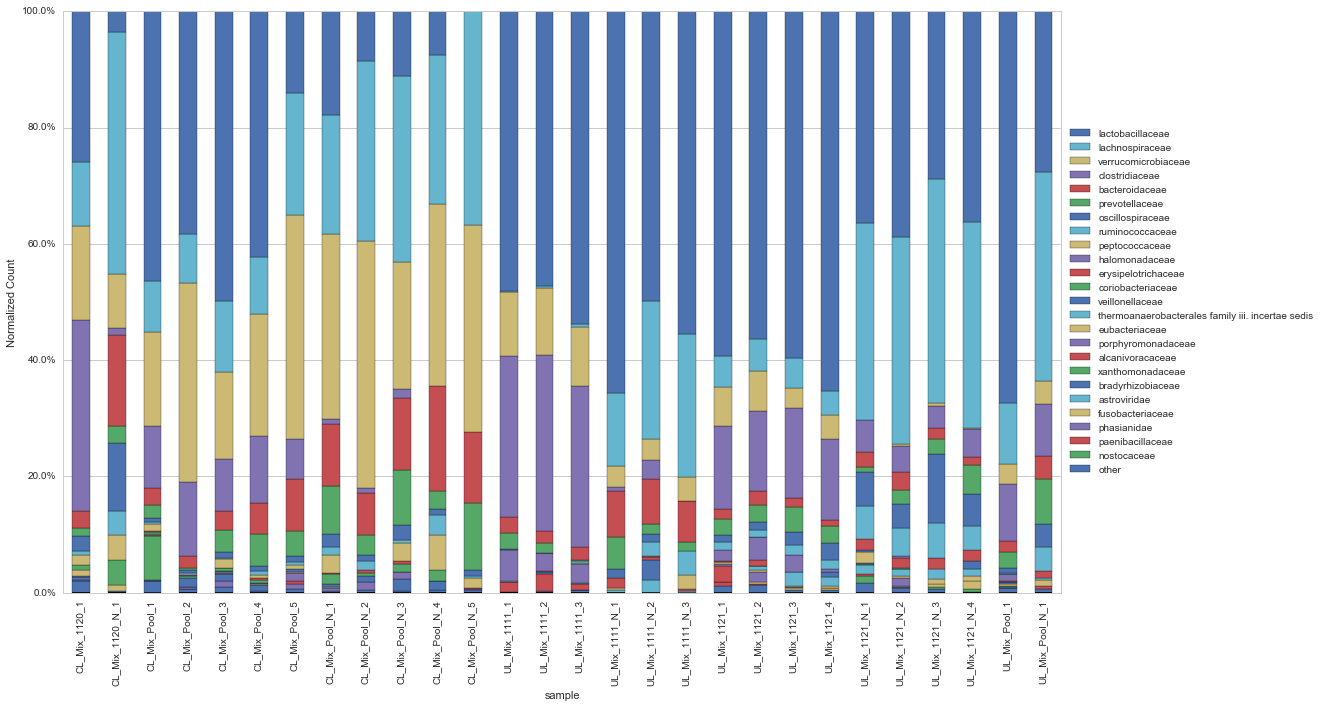

In [16]:
from matplotlib.ticker import FuncFormatter
import matplotlib

rank = "family"
all_df = pd.concat(list(dfs[rank].values()))
f = plt.figure(figsize=(12*1.25,8*1.25))
#matplotlib.style.use('ggplot')
sns.set_style('whitegrid')
df_pivot = all_df.pivot_table(values="count", index="sample", columns="organism_name").dropna(1, thresh=3)
if rank == "family":
    del df_pivot['muridae']
    #del df_pivot['poaceae']
    del df_pivot['hominidae']
    #del df_pivot['phormidiaceae']
elif rank == "phylum":
    del df_pivot['chordata']
    del df_pivot['cyanobacteria']
df_pivot.to_csv(os.path.join(OUT,"{}_count_pivot.csv".format(rank)))
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)
df_pivot = df_pivot[df_pivot.columns[df_pivot.sum()>0.02]]
df_pivot = df_pivot[df_pivot.sum().sort_values().index]
other = pd.Series(1-df_pivot.sum(axis=1), name = "Other")
df_pivot['other'] = other
df_pivot = df_pivot[[-1]+list(range(len(df_pivot.columns)-1))]

ax = df_pivot.plot.bar(stacked=True, legend = 'reverse', ylim=(0,1), ax=f.gca())
lgd = plt.legend()
handles, labels = ax.get_legend_handles_labels()
lgd = plt.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Normalized Count")
ax.title.set_fontsize(20)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
f.subplots_adjust(right=0.8)

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


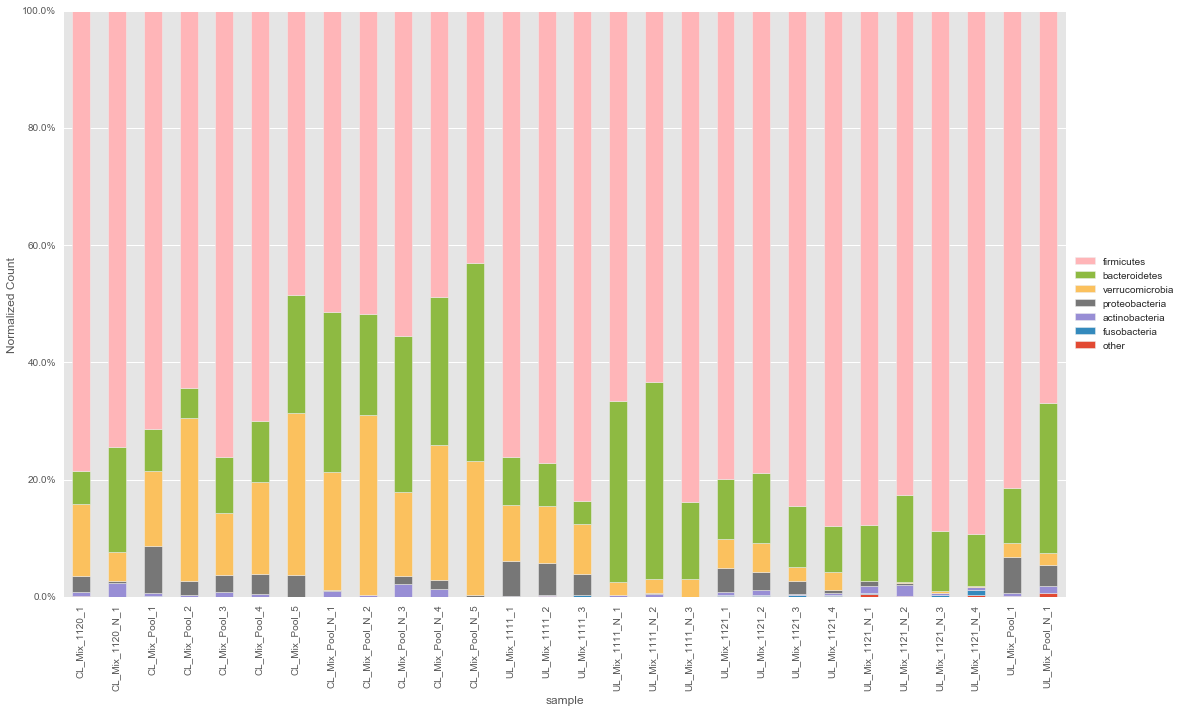

In [17]:
rank = "phylum"
all_df = pd.concat(list(dfs[rank].values()))
f = plt.figure(figsize=(12*1.25,8*1.25))
matplotlib.style.use('ggplot')
df_pivot = all_df.pivot_table(values="count", index="sample", columns="organism_name").dropna(1, thresh=3)
if rank == "family":
    del df_pivot['muridae']
    #del df_pivot['poaceae']
    del df_pivot['hominidae']
    del df_pivot['phormidiaceae']
elif rank == "phylum":
    del df_pivot['chordata']
    del df_pivot['cyanobacteria']
df_pivot.to_csv(os.path.join(OUT,"{}_count_pivot.csv".format(rank)))
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)
df_pivot = df_pivot[df_pivot.columns[df_pivot.sum()>0.02]]
df_pivot = df_pivot[df_pivot.sum().sort_values().index]
other = pd.Series(1-df_pivot.sum(axis=1), name = "Other")
df_pivot['other'] = other
df_pivot = df_pivot[[-1]+list(range(len(df_pivot.columns)-1))]

ax = df_pivot.plot.bar(stacked=True, legend = 'reverse', ylim=(0,1), ax=f.gca())
lgd = plt.legend()
handles, labels = ax.get_legend_handles_labels()
lgd = plt.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Normalized Count")
ax.title.set_fontsize(20)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
f.subplots_adjust(right=0.8)